**XGBoost**

This notebook contains the python code to construct a simple XGBoost Algorithm from scratch. The loss function chosen is the negative log-likelihood (Binary Cross Entropy) with the logit transformation on the predicted scores.

The dataset used here is an email spam dataset. This dataset has 57 continuous predictors and 1 nominal class label, {0, 1}.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from mpl_toolkits.mplot3d import Axes3D

Load the data and do the training and testing dataset split

In [2]:
# load data 
data = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data', header=None)
p_ = data.shape[1]
p = p_ - 1
X = data.iloc[:, :p]
y = data.iloc[:, p]

# split the data to training set and testing test
# the training set will be used to choose hyperparameters
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3680, 57) (921, 57) (3680,) (921,)


**XGB Function class**

In [0]:
# define a function or class to implement the xgboost
#########################################################

class XGBOOST():
    def __init__(self, min_impurity_decrease=0.01, M=5):
        self.min_impurity_decrease = min_impurity_decrease
        self.M = int(M)
        self.weak_classifer = []
        self.score = None
        self.score_t = None
        self.training_acc = []
        self.testing_acc = []
    
    def update_y(self,y,s):
        
        # Use the Negative Log-Lik Loss with logit transformation to score
        neg_first_order = y-1/(1+np.exp(-s))
        second_order = np.exp(-s)/((1+np.exp(-s))**2) + 0.01
        return neg_first_order,second_order
    
    def score_to_label(self,score):
        
        # Transfer the score values to the classification labels
        train_pred = 1/(1+np.exp(-score))
        train_pred[train_pred<=0.5] = 0
        train_pred[train_pred>0.5] = 1
        return train_pred

    def training(self, train_features, train_labels):
        
        n = train_features.shape[0]
        self.score = np.zeros(n)
        y_new = train_labels
        sample_weights = [1/len(y_new) for i in range(len(y_new))]
        
        for i in range(self.M):
            
            # Train the week classifier: a Tree model
            dt = DecisionTreeRegressor(min_impurity_decrease=self.min_impurity_decrease)
            dt.fit(train_features,y_new,sample_weight=sample_weights)
            self.weak_classifer.append(dt) # Store the trained week classifier
            
            # calculate and sum up the object score
            s = dt.predict(train_features)
            self.score =  self.score + s
            first,second = self.update_y(train_labels,self.score)
            y_new = first/second
            sample_weights = second
            
            # Calculate and store the trainig accuracy
            train_pred = self.score_to_label(self.score)
            acc = sum(train_pred==train_labels)/n
            self.training_acc.append(acc)
            
            # Print out the training process
            #print('Adding Tree %d, the training accuracy is %f' %(i+1,acc))
            
        return acc

    def testing(self, test_features, test_labels):
        
        k = test_features.shape[0]
        self.score_t = np.zeros(k)
        
        for i,wc in enumerate(self.weak_classifer):
          
            # Caculate and sum up the object score
            self.score_t = self.score_t + wc.predict(test_features)
            
            # Calculate and store the testing accuracy
            test_pred = self.score_to_label(self.score_t)
            acc_t = sum(test_pred==test_labels)/k
            self.testing_acc.append(acc_t)
            
            # Print out the testing accuracy when adding tree
            #print('Adding Tree %d, the training accuracy is %f' %(i+1,acc_t))
         
        return acc_t

#########################################################

Try the training and testing

In [5]:
xgb = XGBOOST(min_impurity_decrease=0.01,M=10)
print('Start Training the XGB')
xgb.training(X_train,y_train)
print('Start Testing the XGB model')
xgb.testing(X_test,y_test)

Start Training the XGB
Adding Tree 1, the training accuracy is 0.388587
Adding Tree 2, the training accuracy is 0.947283
Adding Tree 3, the training accuracy is 0.961685
Adding Tree 4, the training accuracy is 0.985598
Adding Tree 5, the training accuracy is 0.992663
Adding Tree 6, the training accuracy is 0.997011
Adding Tree 7, the training accuracy is 0.998098
Adding Tree 8, the training accuracy is 0.998370
Adding Tree 9, the training accuracy is 0.998098
Adding Tree 10, the training accuracy is 0.998098
Start Testing the XGB model
Adding Tree 1, the training accuracy is 0.415852
Adding Tree 2, the training accuracy is 0.920738
Adding Tree 3, the training accuracy is 0.930510
Adding Tree 4, the training accuracy is 0.933768
Adding Tree 5, the training accuracy is 0.928339
Adding Tree 6, the training accuracy is 0.928339
Adding Tree 7, the training accuracy is 0.930510
Adding Tree 8, the training accuracy is 0.932682
Adding Tree 9, the training accuracy is 0.932682
Adding Tree 10, t

0.9326818675352877

**Cross Validation**

Do the cross validation to choose the proper value for the hyper parameter.

In [7]:
def cross_validation(log_min_impurity_decreases, Ms, n_splits=5):
    
    min_imp_dec = np.exp(log_min_impurity_decreases)
    n = X_train.shape[0]
    fold_idx = np.linspace(0,n,n_splits+1)
    
    n_min_imp_dec = len(log_min_impurity_decreases)
    n_Ms = len(Ms)
    plot_values = np.zeros(n_min_imp_dec*n_Ms*3).reshape((n_min_imp_dec*n_Ms,3))
    
    # Use three loops to fill in the matrix tracking all CV mean accuracy
    for i,dec in enumerate(min_imp_dec):
        for j,m in enumerate(Ms):
          
            # Record the combination of parameters used
            plot_values[i*n_Ms+j][0] = np.log(dec)
            plot_values[i*n_Ms+j][1] = m
            
            # Do the K-fold cross validation
            mean_acc = 0
            for k in range(n_splits):
                xgb = XGBOOST(dec,m)
                acc = xgb.training(np.delete(X_train,range(int(fold_idx[k]),int(fold_idx[k+1])),axis=0),\
                                   np.delete(y_train,range(int(fold_idx[k]),int(fold_idx[k+1]))))
                acc_t = xgb.testing(X_train[range(int(fold_idx[k]),int(fold_idx[k+1])),:],\
                                    y_train[range(int(fold_idx[k]),int(fold_idx[k+1]))])
                mean_acc = mean_acc + acc_t
            plot_values[i*n_Ms+j][2] = mean_acc/n_splits
            print('Combination No.%d is done, the CV acc is %f' %(i*n_Ms+j+1,mean_acc/n_splits))
    
    # Find the combination for the largest CV mean accuracy
    idx = np.argmax(plot_values[:,2])
    best_log_min_impurity_decrease = plot_values[idx,0]
    best_M = plot_values[idx,1]

    return plot_values, best_log_min_impurity_decrease, best_M

log_min_impurity_decreases = list(range(-8, 0))
Ms = list(range(20, 40, 2))
plot_values, best_log_min_impurity_decrease, best_M = cross_validation(log_min_impurity_decreases=log_min_impurity_decreases, Ms=Ms)

Combination No.1 is done, the CV acc is 0.938315
Combination No.2 is done, the CV acc is 0.935870
Combination No.3 is done, the CV acc is 0.938587
Combination No.4 is done, the CV acc is 0.937228
Combination No.5 is done, the CV acc is 0.937772
Combination No.6 is done, the CV acc is 0.935326
Combination No.7 is done, the CV acc is 0.938043
Combination No.8 is done, the CV acc is 0.936685
Combination No.9 is done, the CV acc is 0.937228
Combination No.10 is done, the CV acc is 0.938315
Combination No.11 is done, the CV acc is 0.932065
Combination No.12 is done, the CV acc is 0.934511
Combination No.13 is done, the CV acc is 0.932337
Combination No.14 is done, the CV acc is 0.933696
Combination No.15 is done, the CV acc is 0.932337
Combination No.16 is done, the CV acc is 0.929620
Combination No.17 is done, the CV acc is 0.935598
Combination No.18 is done, the CV acc is 0.933696
Combination No.19 is done, the CV acc is 0.933967
Combination No.20 is done, the CV acc is 0.932065
Combinati

Plot the accuracy over the hyperparameter values

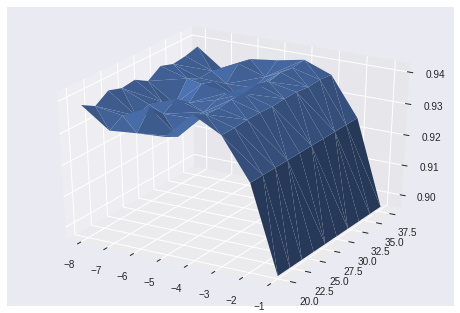

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(plot_values[:, 0], plot_values[:, 1], plot_values[:, 2], linewidth=0.2, antialiased=True)
plt.show()

**Fit the XGBoost Model with selected hyperparameters**

In [10]:
print('Best min_impurity_decrease is %d and the Best M is %d' %(best_log_min_impurity_decrease,best_M))

Best min_impurity_decrease is -4 and the Best M is 20


In [11]:
xgb = XGBOOST(min_impurity_decrease=np.exp(best_log_min_impurity_decrease),M=best_M)
print('Start Training the XGB')
xgb.training(X_train,y_train)

Start Training the XGB
Adding Tree 1, the training accuracy is 0.388587
Adding Tree 2, the training accuracy is 0.918207
Adding Tree 3, the training accuracy is 0.939130
Adding Tree 4, the training accuracy is 0.963043
Adding Tree 5, the training accuracy is 0.976359
Adding Tree 6, the training accuracy is 0.979891
Adding Tree 7, the training accuracy is 0.987500
Adding Tree 8, the training accuracy is 0.989946
Adding Tree 9, the training accuracy is 0.991848
Adding Tree 10, the training accuracy is 0.992935
Adding Tree 11, the training accuracy is 0.994022
Adding Tree 12, the training accuracy is 0.993750
Adding Tree 13, the training accuracy is 0.994022
Adding Tree 14, the training accuracy is 0.994293
Adding Tree 15, the training accuracy is 0.994293
Adding Tree 16, the training accuracy is 0.994293
Adding Tree 17, the training accuracy is 0.994293
Adding Tree 18, the training accuracy is 0.994293
Adding Tree 19, the training accuracy is 0.994293
Adding Tree 20, the training accurac

0.9942934782608696

Do the testing part

In [12]:
print('Start Testing the XGB model')
xgb.testing(X_test,y_test)

Start Testing the XGB model
Adding Tree 1, the training accuracy is 0.415852
Adding Tree 2, the training accuracy is 0.912052
Adding Tree 3, the training accuracy is 0.921824
Adding Tree 4, the training accuracy is 0.939197
Adding Tree 5, the training accuracy is 0.933768
Adding Tree 6, the training accuracy is 0.934853
Adding Tree 7, the training accuracy is 0.935939
Adding Tree 8, the training accuracy is 0.939197
Adding Tree 9, the training accuracy is 0.940282
Adding Tree 10, the training accuracy is 0.939197
Adding Tree 11, the training accuracy is 0.939197
Adding Tree 12, the training accuracy is 0.938111
Adding Tree 13, the training accuracy is 0.938111
Adding Tree 14, the training accuracy is 0.938111
Adding Tree 15, the training accuracy is 0.938111
Adding Tree 16, the training accuracy is 0.938111
Adding Tree 17, the training accuracy is 0.938111
Adding Tree 18, the training accuracy is 0.938111
Adding Tree 19, the training accuracy is 0.938111
Adding Tree 20, the training ac

0.9381107491856677